<a href="https://colab.research.google.com/github/TUstudents/gpHSP/blob/master/1_validate_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! rm -rf gpHSP
!git clone https://github.com/aspuru-guzik-group/gpHSP

Cloning into 'gpHSP'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 147 (delta 65), reused 79 (delta 35), pack-reused 38
Receiving objects: 100% (147/147), 32.98 MiB | 29.78 MiB/s, done.
Resolving deltas: 100% (79/79), done.


# Assuming in a colab enviroment

In [3]:
import sys
if 'google.colab' in sys.modules:
    print('In colab!')
    sys.path.insert(0,'gpHSP')
    !pip install ml_collections ngboost gpflow

In colab!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 9.1 MB/s eta 0:00:00
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94505 sha256=b45936ac8bebe16d123e6fa05bc460bb61f36bbb288cbe7af978e28ad219cce2
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=0440fcad176549844c32fb85ed8b17a4a226091f9b80207

In [4]:
pip install mordredcommunity[full] dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 28.8 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import scipy.stats as stats

import sklearn.model_selection
import sklearn.preprocessing
import ngboost
import seaborn as sns
import tensorflow as tf
import gpflow as gpf
import gphsp
from gphsp import cast_1d_array

gphsp.notebook_context()
gphsp.print_modules([ngboost, tf , gpf])

ngboost    = 0.5.1
tensorflow = 2.15.0
gpflow     = 2.9.1


In [6]:
!cp -r -v /content/gdrive/MyDrive/gpHSP/data /content/gpHSP/

'/content/gdrive/MyDrive/gpHSP/data/sample_molecules.csv' -> '/content/gpHSP/data/sample_molecules.csv'
'/content/gdrive/MyDrive/gpHSP/data/Polymers_exp.csv' -> '/content/gpHSP/data/Polymers_exp.csv'
'/content/gdrive/MyDrive/gpHSP/data/Solvents_exp.csv' -> '/content/gpHSP/data/Solvents_exp.csv'
'/content/gdrive/MyDrive/gpHSP/data/mordred_features.npz' -> '/content/gpHSP/data/mordred_features.npz'
'/content/gdrive/MyDrive/gpHSP/data/Solvents_exp_REF.csv' -> '/content/gpHSP/data/Solvents_exp_REF.csv'
'/content/gdrive/MyDrive/gpHSP/data/HSPiP.csv' -> '/content/gpHSP/data/HSPiP.csv'


## Utilities

In [7]:
at_data_dir = lambda x: os.path.join('gpHSP/data', x)
at_model_dir = lambda x: os.path.join('gpHSP/models', x)

# Load data and get all smiles

In [8]:
df = pd.read_csv(at_data_dir('Solvents_exp.csv'))
df['smiles'] = df['smiles'].apply(gphsp.get_isomeric_smiles)
gphsp.peek_df(df)

Index(['key', 'Type', 'δd', 'δp', 'δh', 'smiles', 'ID_type', 'ID', 'Ref',
       'organic', 'n_electrons', 'n_atoms', 'charge', 'MolWt', 'label',
       'finished', 'job_name', 'homo', 'lumo', 'gap', 'd-moments', 'dipole',
       'polar', 'run_time', 'n_cores', 'compute_time', 'Area', 'Hba', 'Hbd',
       'Volume', 'sigma_mom_0', 'sigma_mom_1', 'sigma_mom_2', 'sigma_mom_3',
       'sigma_mom_4', 'sigma_mom_5', 'sigma_norm', 'sigma_profile', 'drug'],
      dtype='object')
(193, 39)


,key,Type,δd,δp,δh,smiles,ID_type,ID,Ref,organic,...,Volume,sigma_mom_0,sigma_mom_1,sigma_mom_2,sigma_mom_3,sigma_mom_4,sigma_mom_5,sigma_norm,sigma_profile,drug
0,"1,1,1-Trichloroethane",Solvent,16.8,4.3,2.0,CC(Cl)(Cl)Cl,CAS,71-55-6,1,True,...,0.126,0,16.6,-3.836,4.24,-2.021,1.54,41.428,[ 0. 0. 0. 0. ...,False


In [9]:
poly_df = pd.read_csv(at_data_dir('Polymers_exp.csv'))
poly_df['smiles'] = poly_df['smiles'].apply(gphsp.get_isomeric_smiles)
gphsp.peek_df(poly_df)

Index(['label', 'δd', 'δp', 'δh', 'smiles', 'test', 'poly_label', 'n_copies',
       'organic', 'n_electrons', 'n_atoms', 'charge', 'MolWt', 'n_frags',
       'largest', 'finished', 'job_name', 'poly_smiles', 'homo', 'lumo', 'gap',
       'd-moments', 'dipole', 'polar', 'run_time', 'n_cores', 'compute_time',
       'Area', 'Hba', 'Hbd', 'Volume', 'sigma_mom_0', 'sigma_mom_1',
       'sigma_mom_2', 'sigma_mom_3', 'sigma_mom_4', 'sigma_mom_5',
       'sigma_norm', 'sigma_profile'],
      dtype='object')
(31, 39)


,label,δd,δp,δh,smiles,test,poly_label,n_copies,organic,n_electrons,...,Hbd,Volume,sigma_mom_0,sigma_mom_1,sigma_mom_2,sigma_mom_3,sigma_mom_4,sigma_mom_5,sigma_norm,sigma_profile
0,Polyacrylonitrile-n5,20.0,15.1,7.9,CCC#N,True,Polyacrylonitrile,5,True,110,...,0.22,0.343,0,175.0,26.1,154.0,51.4,165.0,66.77,[ 0. 0. 0. 0. ...


Load features

In [10]:
features = gphsp.SmilesMap(at_data_dir('mordred_features.npz'))

# Train rfHSP model on single molecules

In [11]:
results = []
x = features(df['smiles'].to_numpy(str)).astype(np.float64)
n_splits = 5
indices = np.arange(len(x))
names = gphsp.Y_COLS
for name in tqdm(names, total=len(names)):
    y = df[name].to_numpy(np.float64).reshape(-1,1)
    spliter = sklearn.model_selection.KFold(n_splits, shuffle=True, random_state=42)
    y_mean_rf, y_mean_gp = np.zeros_like(indices), np.zeros_like(indices)
    y_std_rf, y_std_gp = np.zeros_like(indices), np.zeros_like(indices)
    for train_index, test_index in tqdm(spliter.split(indices), total=n_splits):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = ngboost.NGBRegressor().fit(x_train, y_train.ravel())
        y_dists = model.pred_dist(x_test)
        y_mean_rf[test_index] = y_dists.mean().ravel()
        y_std_rf[test_index] = y_dists.std().ravel()

        # Standarize target
        preproc = sklearn.preprocessing.StandardScaler()
        y_train = preproc.fit_transform(y_train)

        model = gphsp.make_gp(x_train, y_train, False, None)
        y_mu, y_std = model.predict_f(x_test)
        y_mean_gp[test_index] = cast_1d_array(preproc.inverse_transform(y_mu.numpy()))
        y_std_gp[test_index] = cast_1d_array(y_std)*preproc.scale_

    results.append(gphsp.evaluate(y, y_mean_rf, y_std_rf, {'name':name, 'method':'ngboost'}))
    results.append(gphsp.evaluate(y, y_mean_gp, y_std_gp, {'name':name, 'method':'gp'}))
    display(pd.DataFrame(results[-2:]))

results_df = pd.DataFrame(results)
results_df

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[iter 0] loss=2.0688 val_loss=0.0000 scale=1.0000 norm=1.6247
[iter 100] loss=1.3792 val_loss=0.0000 scale=2.0000 norm=1.7279
[iter 200] loss=0.7340 val_loss=0.0000 scale=2.0000 norm=1.1651
[iter 300] loss=0.2134 val_loss=0.0000 scale=1.0000 norm=0.4620
[iter 400] loss=-0.1289 val_loss=0.0000 scale=1.0000 norm=0.3990
[iter 0] loss=2.0192 val_loss=0.0000 scale=1.0000 norm=1.5470
[iter 100] loss=1.2761 val_loss=0.0000 scale=1.0000 norm=0.7993
[iter 200] loss=0.6790 val_loss=0.0000 scale=2.0000 norm=1.1282
[iter 300] loss=0.2127 val_loss=0.0000 scale=1.0000 norm=0.4599
[iter 400] loss=-0.1204 val_loss=0.0000 scale=1.0000 norm=0.3992
[iter 0] loss=2.0605 val_loss=0.0000 scale=1.0000 norm=1.6099
[iter 100] loss=1.2560 val_loss=0.0000 scale=2.0000 norm=1.5538
[iter 200] loss=0.5433 val_loss=0.0000 scale=2.0000 norm=1.0546
[iter 300] loss=-0.0111 val_loss=0.0000 scale=2.0000 norm=0.8439
[iter 400] loss=-0.3709 val_loss=0.0000 scale=1.0000 norm=0.3690
[iter 0] loss=1.9760 val_loss=0.0000 scale

,name,method,R2,MAE,tau,uncertainty_tau
0,δd,ngboost,0.316,1.033,0.589,NaN
1,δd,gp,-0.012,1.412,-0.064,NaN


  0%|          | 0/5 [00:00<?, ?it/s]

[iter 0] loss=3.0512 val_loss=0.0000 scale=1.0000 norm=4.1291
[iter 100] loss=2.4740 val_loss=0.0000 scale=1.0000 norm=2.2662
[iter 200] loss=1.8780 val_loss=0.0000 scale=2.0000 norm=2.5890
[iter 300] loss=1.3008 val_loss=0.0000 scale=1.0000 norm=0.9096
[iter 400] loss=0.8704 val_loss=0.0000 scale=1.0000 norm=0.7272
[iter 0] loss=3.0900 val_loss=0.0000 scale=1.0000 norm=4.2681
[iter 100] loss=2.4715 val_loss=0.0000 scale=1.0000 norm=2.2474
[iter 200] loss=1.8801 val_loss=0.0000 scale=2.0000 norm=2.5659
[iter 300] loss=1.3481 val_loss=0.0000 scale=1.0000 norm=0.8842
[iter 400] loss=1.0096 val_loss=0.0000 scale=2.0000 norm=1.4311
[iter 0] loss=3.0941 val_loss=0.0000 scale=1.0000 norm=4.1960
[iter 100] loss=2.4755 val_loss=0.0000 scale=1.0000 norm=2.2681
[iter 200] loss=1.8101 val_loss=0.0000 scale=2.0000 norm=2.4847
[iter 300] loss=1.2558 val_loss=0.0000 scale=2.0000 norm=1.7928
[iter 400] loss=0.8699 val_loss=0.0000 scale=2.0000 norm=1.4593
[iter 0] loss=3.0850 val_loss=0.0000 scale=1.0

,name,method,R2,MAE,tau,uncertainty_tau
0,δp,ngboost,0.514,2.518,0.610,0.120
1,δp,gp,-0.024,4.126,-0.069,-0.015


  0%|          | 0/5 [00:00<?, ?it/s]

[iter 0] loss=3.2078 val_loss=0.0000 scale=1.0000 norm=4.7793
[iter 100] loss=2.2799 val_loss=0.0000 scale=2.0000 norm=3.2954
[iter 200] loss=1.5176 val_loss=0.0000 scale=2.0000 norm=1.9063
[iter 300] loss=0.8680 val_loss=0.0000 scale=2.0000 norm=1.4474
[iter 400] loss=0.4287 val_loss=0.0000 scale=1.0000 norm=0.6162
[iter 0] loss=3.1454 val_loss=0.0000 scale=1.0000 norm=4.6482
[iter 100] loss=2.2995 val_loss=0.0000 scale=2.0000 norm=3.2669
[iter 200] loss=1.4898 val_loss=0.0000 scale=2.0000 norm=1.6703
[iter 300] loss=0.7864 val_loss=0.0000 scale=2.0000 norm=1.1698
[iter 400] loss=0.3486 val_loss=0.0000 scale=1.0000 norm=0.4818
[iter 0] loss=3.1566 val_loss=0.0000 scale=1.0000 norm=4.6127
[iter 100] loss=2.3468 val_loss=0.0000 scale=2.0000 norm=3.5928
[iter 200] loss=1.5451 val_loss=0.0000 scale=2.0000 norm=1.9097
[iter 300] loss=0.8833 val_loss=0.0000 scale=2.0000 norm=1.4470
[iter 400] loss=0.4316 val_loss=0.0000 scale=2.0000 norm=1.2146
[iter 0] loss=3.1856 val_loss=0.0000 scale=1.0

,name,method,R2,MAE,tau,uncertainty_tau
0,δh,ngboost,0.687,2.045,0.732,0.050
1,δh,gp,0.005,4.616,0.119,-0.023


,name,method,R2,MAE,tau,uncertainty_tau
0,δd,ngboost,0.316,1.033,0.589,NaN
1,δd,gp,-0.012,1.412,-0.064,NaN
2,δp,ngboost,0.514,2.518,0.610,0.120
3,δp,gp,-0.024,4.126,-0.069,-0.015
4,δh,ngboost,0.687,2.045,0.732,0.050
5,δh,gp,0.005,4.616,0.119,-0.023


In [12]:
results_df = pd.DataFrame(results)
results_df

,name,method,R2,MAE,tau,uncertainty_tau
0,δd,ngboost,0.316,1.033,0.589,NaN
1,δd,gp,-0.012,1.412,-0.064,NaN
2,δp,ngboost,0.514,2.518,0.610,0.120
3,δp,gp,-0.024,4.126,-0.069,-0.015
4,δh,ngboost,0.687,2.045,0.732,0.050
5,δh,gp,0.005,4.616,0.119,-0.023


<Axes: xlabel='name', ylabel='R2'>

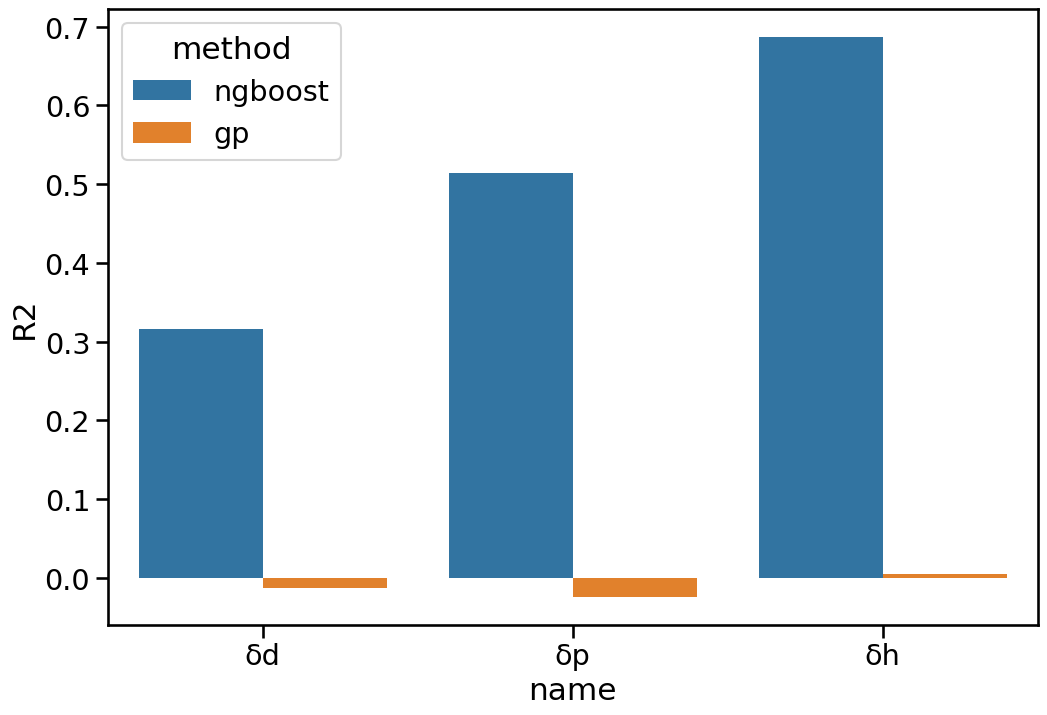

In [13]:
sns.barplot(x='name', y='R2', hue='method', data=results_df)

# Train gpHSP model on polymers

In [14]:
def predictions_as_features(x, model_dict, pred_fn=None):
    default_pred_fn = lambda model, inputs: model.pred_dist(inputs)
    pred_fn = pred_fn or default_pred_fn
    new_x = np.zeros((len(x), 6), dtype=np.float64)
    for index, name in enumerate(names):
        y_mol_dist = pred_fn(models[name], x)
        new_x[:,index] = y_mol_dist.mean()
        new_x[:,index+3] = y_mol_dist.mean()
    return new_x


In [15]:
model_suffix = 'HSP_ngboost_mol.pkl'
names = gphsp.Y_COLS
models = {name: gphsp.load_model(at_model_dir(f"{name}_{model_suffix}")) for name in names}
mol_x = features(poly_df['smiles'].to_numpy(str)).astype(np.float64)
x = predictions_as_features(mol_x, models)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [16]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

results = []
indices = np.arange(len(x))
n_splits = len(indices)
names = gphsp.Y_COLS
gp_parts = {'mean':[0,1, 2], 'std':[3, 4, 5]}

for index, name in tqdm(enumerate(names), total=len(names)):
    y = poly_df[name].to_numpy(np.float64).reshape(-1,1)
    spliter = sklearn.model_selection.LeaveOneOut()
    y_mean_rf, y_std_rf = np.zeros_like(indices), np.zeros_like(indices)
    y_mean_mol, y_std_mol = np.zeros_like(indices), np.zeros_like(indices)
    y_mean_gp, y_std_gp = np.zeros_like(indices), np.zeros_like(indices)
    y_mean_lin = np.zeros_like(indices)

    for train_index, test_index in tqdm(spliter.split(indices), total=n_splits):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #RF model
        model = ngboost.NGBRegressor().fit(x_train, y_train.ravel())
        y_dists = model.pred_dist(x_test)
        y_mean_rf[test_index] = y_dists.mean().ravel()
        y_std_rf[test_index] = y_dists.std().ravel()

        # Linear model
        x_train, x_test = mol_x[train_index], mol_x[test_index]
        model = sklearn.linear_model.LassoCV()
        model.fit(x_train, y_train.ravel())
        y_mu = model.predict(x_test)
        y_mean_lin[test_index] = cast_1d_array(y_mu)

        # Standarize target
        #preproc = sklearn.preprocessing.StandardScaler()
        #y_train = preproc.fit_transform(y_train)

        model = gphsp.make_gp(x_train, y_train, True, gp_parts)
        y_mu, y_std = model.predict_f(x_test)
        y_mean_gp[test_index] = cast_1d_array(y_mu)
        y_std_gp[test_index] = cast_1d_array(y_std)

        x_train, x_test = mol_x[train_index], mol_x[test_index]
        model = gphsp.make_gp(x_train, y_train, False, None)
        y_mu, y_std = model.predict_f(x_test)
        y_mean_mol[test_index] = cast_1d_array(y_mu)
        y_std_mol[test_index] = cast_1d_array(y_std)


    results.append(gphsp.evaluate(y, y_mean_rf, y_std_rf, {'name':name, 'method':'ngboost', 'feature':'HSP'}))
    results.append(gphsp.evaluate(y, y_mean_gp, y_std_gp, {'name':name, 'method':'gp', 'feature':'HSP'}))
    results.append(gphsp.evaluate(y, y_mean_mol, y_std_mol, {'name':name, 'method':'gp', 'feature':'mol'}))
    results.append(gphsp.evaluate(y, y_mean_lin, info={'name':name, 'method':'linear', 'feature':'mol'}))
    display(pd.DataFrame(results[-4:]))
results_df = pd.DataFrame(results)
gphsp.peek_df(results_df)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[iter 0] loss=1.2244 val_loss=0.0000 scale=1.0000 norm=0.8618
[iter 100] loss=0.5955 val_loss=0.0000 scale=1.0000 norm=0.5283
[iter 200] loss=-0.1971 val_loss=0.0000 scale=2.0000 norm=0.8758
[iter 300] loss=-1.0049 val_loss=0.0000 scale=2.0000 norm=0.8410
[iter 400] loss=-1.8042 val_loss=0.0000 scale=2.0000 norm=0.8308
[iter 0] loss=1.2684 val_loss=0.0000 scale=1.0000 norm=0.8951
[iter 100] loss=0.6007 val_loss=0.0000 scale=1.0000 norm=0.5424
[iter 200] loss=-0.0565 val_loss=0.0000 scale=2.0000 norm=0.8645
[iter 300] loss=-0.7630 val_loss=0.0000 scale=2.0000 norm=0.7743
[iter 400] loss=-1.3531 val_loss=0.0000 scale=1.0000 norm=0.3604
[iter 0] loss=1.3034 val_loss=0.0000 scale=1.0000 norm=0.9155
[iter 100] loss=0.6830 val_loss=0.0000 scale=2.0000 norm=1.1125
[iter 200] loss=-0.0804 val_loss=0.0000 scale=2.0000 norm=0.8723
[iter 300] loss=-0.8343 val_loss=0.0000 scale=2.0000 norm=0.8096
[iter 400] loss=-1.5443 val_loss=0.0000 scale=2.0000 norm=0.7643
[iter 0] loss=1.2975 val_loss=0.0000 

,name,method,feature,R2,MAE,tau,uncertainty_tau
0,δd,ngboost,HSP,-0.572,0.841,0.298,NaN
1,δd,gp,HSP,-0.452,0.829,0.344,NaN
2,δd,gp,mol,0.124,0.667,0.343,-0.255
3,δd,linear,mol,-0.702,0.950,-0.053,NaN


  0%|          | 0/31 [00:00<?, ?it/s]

[iter 0] loss=2.7972 val_loss=0.0000 scale=1.0000 norm=3.3813
[iter 100] loss=1.8634 val_loss=0.0000 scale=2.0000 norm=2.4969
[iter 200] loss=1.1195 val_loss=0.0000 scale=2.0000 norm=1.4542
[iter 300] loss=0.4572 val_loss=0.0000 scale=2.0000 norm=1.1115
[iter 400] loss=-0.1036 val_loss=0.0000 scale=2.0000 norm=0.9681
[iter 0] loss=2.8317 val_loss=0.0000 scale=2.0000 norm=7.0518
[iter 100] loss=2.1102 val_loss=0.0000 scale=2.0000 norm=3.1389
[iter 200] loss=1.3131 val_loss=0.0000 scale=2.0000 norm=1.5939
[iter 300] loss=0.5679 val_loss=0.0000 scale=2.0000 norm=1.1349
[iter 400] loss=-0.0745 val_loss=0.0000 scale=2.0000 norm=0.9631
[iter 0] loss=2.8211 val_loss=0.0000 scale=1.0000 norm=3.5022
[iter 100] loss=2.1194 val_loss=0.0000 scale=1.0000 norm=1.5859
[iter 200] loss=1.3215 val_loss=0.0000 scale=2.0000 norm=1.5974
[iter 300] loss=0.6147 val_loss=0.0000 scale=2.0000 norm=1.1537
[iter 400] loss=-0.0921 val_loss=0.0000 scale=2.0000 norm=0.9655
[iter 0] loss=2.8665 val_loss=0.0000 scale=

,name,method,feature,R2,MAE,tau,uncertainty_tau
0,δp,ngboost,HSP,0.173,2.809,0.386,NaN
1,δp,gp,HSP,-0.146,3.462,-0.033,-0.333
2,δp,gp,mol,0.031,3.269,0.266,-0.428
3,δp,linear,mol,0.055,3.067,0.250,NaN


  0%|          | 0/31 [00:00<?, ?it/s]

[iter 0] loss=2.9031 val_loss=0.0000 scale=1.0000 norm=3.3796
[iter 100] loss=2.0491 val_loss=0.0000 scale=2.0000 norm=2.8063
[iter 200] loss=1.2769 val_loss=0.0000 scale=2.0000 norm=1.5877
[iter 300] loss=0.4857 val_loss=0.0000 scale=2.0000 norm=1.2312
[iter 400] loss=-0.2721 val_loss=0.0000 scale=2.0000 norm=1.1293
[iter 0] loss=2.8897 val_loss=0.0000 scale=1.0000 norm=3.3140
[iter 100] loss=2.0413 val_loss=0.0000 scale=2.0000 norm=2.8073
[iter 200] loss=1.2793 val_loss=0.0000 scale=2.0000 norm=1.6174
[iter 300] loss=0.4819 val_loss=0.0000 scale=2.0000 norm=1.2333
[iter 400] loss=-0.2701 val_loss=0.0000 scale=2.0000 norm=1.1134
[iter 0] loss=2.8733 val_loss=0.0000 scale=1.0000 norm=3.2658
[iter 100] loss=1.9992 val_loss=0.0000 scale=2.0000 norm=2.7075
[iter 200] loss=1.2303 val_loss=0.0000 scale=2.0000 norm=1.5780
[iter 300] loss=0.4455 val_loss=0.0000 scale=2.0000 norm=1.2224
[iter 400] loss=-0.2934 val_loss=0.0000 scale=2.0000 norm=1.1011
[iter 0] loss=2.8943 val_loss=0.0000 scale=

,name,method,feature,R2,MAE,tau,uncertainty_tau
0,δh,ngboost,HSP,0.170,2.922,0.334,0.136
1,δh,gp,HSP,-0.054,3.179,-0.255,NaN
2,δh,gp,mol,-0.083,3.276,-0.284,0.183
3,δh,linear,mol,-0.009,3.056,0.104,NaN


Index(['name', 'method', 'feature', 'R2', 'MAE', 'tau', 'uncertainty_tau'], dtype='object')
(12, 7)


,name,method,feature,R2,MAE,tau,uncertainty_tau
0,δd,ngboost,HSP,-0.572,0.841,0.298,NaN


In [17]:
!cp -r -v /content/gpHSP/models /content/gdrive/MyDrive/gpHSP/

'/content/gpHSP/models' -> '/content/gdrive/MyDrive/gpHSP/models'
'/content/gpHSP/models/δd_HSP_ngboost_mol.pkl' -> '/content/gdrive/MyDrive/gpHSP/models/δd_HSP_ngboost_mol.pkl'
'/content/gpHSP/models/δd_ngboost_polymer.pkl' -> '/content/gdrive/MyDrive/gpHSP/models/δd_ngboost_polymer.pkl'
'/content/gpHSP/models/δh_HSP_ngboost_mol.pkl' -> '/content/gdrive/MyDrive/gpHSP/models/δh_HSP_ngboost_mol.pkl'
'/content/gpHSP/models/δh_ngboost_polymer.pkl' -> '/content/gdrive/MyDrive/gpHSP/models/δh_ngboost_polymer.pkl'
'/content/gpHSP/models/δp_HSP_ngboost_mol.pkl' -> '/content/gdrive/MyDrive/gpHSP/models/δp_HSP_ngboost_mol.pkl'
'/content/gpHSP/models/δp_ngboost_polymer.pkl' -> '/content/gdrive/MyDrive/gpHSP/models/δp_ngboost_polymer.pkl'
